# Brendan's Notebook
## Brainstorm

### Winrates of decks based on composition in terms of card types

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from collections import Counter

data_games = pd.read_csv("data_ord.csv")
data_cards = pd.read_csv("cardlist.csv")

# Extracting interesting deck data
dict_decks_general = {} 
dict_decks_general = defaultdict(lambda:0,dict_decks_general)
dict_decks_winning_only = {} 
dict_decks_winning_only = defaultdict(lambda:0,dict_decks_winning_only)
def get_decks(p1_deck,p2_deck,result):
    global dict_decks_general
    global dict_decks_winning_only
    dict_decks_general[p1_deck] = dict_decks_general[p1_deck] + 1
    dict_decks_general[p2_deck] = dict_decks_general[p2_deck] + 1
    if(result == 1):
        dict_decks_winning_only[p1_deck] = dict_decks_winning_only[p1_deck] + 1
    else:
        dict_decks_winning_only[p2_deck] = dict_decks_winning_only[p2_deck] + 1
        
data_games.apply(lambda x: get_decks((x["p1card1"],x["p1card2"],x["p1card3"],x["p1card4"],x["p1card5"],x["p1card6"],x["p1card7"],x["p1card8"]),(x["p2card1"],x["p2card2"],x["p2card3"],x["p2card4"],x["p2card5"],x["p2card6"],x["p2card7"],x["p2card8"]),x["outcome"]), axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
718881    None
718882    None
718883    None
718884    None
718885    None
Length: 718886, dtype: object

In [2]:
# Exploring deck data found
most_common_decks = Counter(dict_decks_general).most_common()
print("There are "+str(len(most_common_decks)) + " unique decks used")
print("\n")
print("These are the 5 most popular decks")
print(most_common_decks[1:5])
print("\n")
number_of_one_off_decks = Counter(dict_decks_general.values()).most_common(1)
print("There were " + str(number_of_one_off_decks[0][1]) + " decks used only once")
print("\n")
most_common_winning_decks = Counter(dict_decks_winning_only).most_common()
print("There are "+str(len(most_common_winning_decks)) + " decks that earned a win")
print("\n")
print("These are the 5 decks with the most wins")
print(most_common_winning_decks[1:5])

There are 327658 unique decks used


These are the 5 most popular decks
[((4, 36, 42, 46, 50, 62, 87, 95), 24027), ((0, 26, 30, 41, 77, 90, 91, 98), 18166), ((6, 34, 35, 37, 63, 92, 99, 102), 16286), ((0, 1, 10, 72, 80, 82, 87, 98), 10385)]


There were 232547 decks used only once


There are 169313 decks that earned a win


These are the 5 decks with the most wins
[((4, 36, 42, 46, 50, 62, 87, 95), 12734), ((6, 34, 35, 37, 63, 92, 99, 102), 9002), ((0, 26, 30, 41, 77, 90, 91, 98), 8849), ((0, 1, 10, 72, 80, 82, 87, 98), 5229)]


In [180]:
# Extracting winrates of decks
import math
dict_win_rate = {}
dict_win_rate = defaultdict(lambda:0,dict_win_rate)
decks = []
win_rates = []
occurences = []
relative_imp = []
comp = []

# This function finds the confidence that a score is relevant to our calculations
# This is important since decks used once are not as relevant when compared to decks used many times
# n = number of times this deck was used, k = number of wins for the deck
# Return value -> lower bound of range (how useful the information is basically)

def AgrestiCoullLower(n, k):
    # 95% confidence interval
    kappa = 2.24140273 #kappa = ierfc(conf/2)*sqrt(2)
    kest = k+kappa*kappa/2
    nest =n+kappa*kappa;
    pest=kest/nest;
    radius=kappa*math.sqrt(pest*(1-pest)/nest);
    return max(0,pest-radius); #Lower bound
    #Upper bound is min(1,pest+radius)
    
for (deck, count) in most_common_decks:
    dict_win_rate[deck] = (dict_decks_winning_only[deck]/count)*100
    decks.append(deck)
    win_rates.append((dict_decks_winning_only[deck]/count)*100)
    occurences.append(count)
    relative_imp.append(AgrestiCoullLower(count,dict_decks_winning_only[deck])*100)
    unit = 0
    spell = 0
    building = 0
    for card in deck:
        curr_type = data_cards.loc[card].type
        if(curr_type == "unit"):
            unit += 1
        elif(curr_type == "spell"):
            spell += 1
        elif(curr_type == "defense" or curr_type == "spawner" or curr_type == "siege" or curr_type == "building"):
            building += 1
    comp.append(str(unit+spell*10+building*100).zfill(3))
    
win_rate = Counter(dict_win_rate).most_common()
print(win_rate[1:10])

# extracting win_rate data as a
data_win_rate = pd.DataFrame({"deck": decks, "win_rate": win_rates, "occurences": occurences, "relative_importance": relative_imp, 'composition': comp, 'units': units, 'spells': spells, 'buildings': buildings})
data_win_rate["relative_importance"].max()

[((6, 10, 11, 56, 77, 80, 88, 98), 100.0), ((7, 27, 34, 37, 52, 92, 97, 99), 100.0), ((9, 12, 13, 48, 49, 67, 70, 99), 100.0), ((4, 14, 27, 51, 94, 95, 99, 102), 100.0), ((12, 21, 31, 40, 43, 45, 49, 98), 100.0), ((2, 4, 7, 41, 49, 72, 74, 105), 100.0), ((5, 11, 14, 18, 24, 51, 88, 98), 100.0), ((4, 27, 42, 51, 62, 71, 94, 102), 100.0), ((11, 12, 32, 49, 68, 87, 98, 105), 100.0)]


79.94813609283649

In [181]:
# Extracting win-rate of 500 most popular decks
most_common_500 = most_common_decks[1:500]
win_rate_common_500 = {} 
win_rate_common_500 = defaultdict(lambda:0,win_rate_common_500)
for (deck, count) in most_common_500:
    win_rate_common_500[deck] = dict_win_rate[deck]

# Finding the 10 decks with the highest win-rate from this list
most_common_win_rate = Counter(win_rate_common_500).most_common()
print(most_common_win_rate[1:10])

[((6, 34, 35, 37, 68, 92, 99, 102), 62.43386243386243), ((5, 6, 12, 22, 29, 32, 41, 88), 61.76470588235294), ((9, 15, 35, 43, 63, 99, 102, 103), 61.575178997613364), ((36, 42, 46, 50, 54, 62, 102, 104), 61.32404181184668), ((5, 6, 8, 29, 32, 37, 88, 95), 60.45454545454545), ((16, 26, 27, 40, 53, 90, 91, 98), 60.290556900726386), ((11, 12, 13, 31, 58, 80, 86, 87), 60.285714285714285), ((47, 52, 57, 59, 85, 87, 88, 98), 60.0), ((4, 42, 50, 51, 62, 69, 87, 102), 59.818731117824775)]


In [182]:
# Extracting win-rate of decks 500 decks with the most wins
most_common_winning_500 = most_common_winning_decks[1:500]
win_rate_winning_500 = {} 
win_rate_winning_500 = defaultdict(lambda:0,win_rate_winning_500)
for (deck, count) in most_common_winning_500:
    win_rate_winning_500[deck] = dict_win_rate[deck]

# Finding the 10 decks with the highest win-rate from this list
most_winning_win_rate = Counter(win_rate_winning_500).most_common()
print(most_winning_win_rate[1:10])

[((6, 15, 34, 35, 63, 92, 99, 102), 63.46153846153846), ((15, 39, 42, 69, 83, 96, 97, 102), 62.66666666666667), ((8, 29, 32, 37, 57, 70, 83, 88), 62.43386243386243), ((6, 34, 35, 37, 68, 92, 99, 102), 62.43386243386243), ((0, 26, 41, 56, 77, 90, 91, 98), 62.27544910179641), ((37, 48, 63, 65, 66, 88, 89, 99), 62.17948717948718), ((4, 36, 42, 46, 50, 62, 96, 104), 61.963190184049076), ((5, 6, 12, 22, 29, 32, 41, 88), 61.76470588235294), ((9, 15, 35, 43, 63, 99, 102, 103), 61.575178997613364)]


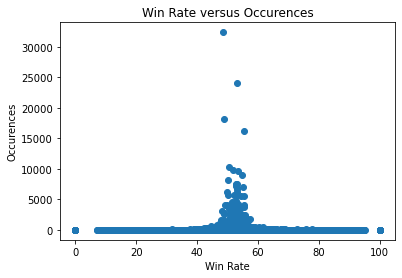

In [183]:
# Creating plot
fig, ax = plt.subplots()
# Setting labels
ax.set_ylabel("Occurences")
ax.set_xlabel("Win Rate")
ax.set_title("Win Rate versus Occurences")
# Plotting year by life expectancy
ax.scatter(data_win_rate["win_rate"],data_win_rate["occurences"])
fig.show()

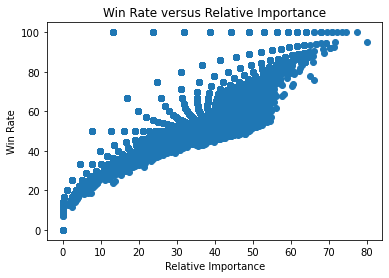

In [184]:
fig, ax = plt.subplots()
# Setting labels
ax.set_xlabel("Relative Importance")
ax.set_ylabel("Win Rate")
ax.set_title("Win Rate versus Relative Importance")
# Plotting year by life expectancy
ax.scatter(data_win_rate["relative_importance"], data_win_rate["win_rate"])
fig.show()

In [187]:
# Finding 5 most relevant decks in the meta
data_win_rate["overall_rank"]= data_win_rate[['win_rate', 'relative_importance']].sum(1)
data_win_rate.sort_values(by=['overall_rank'], ascending=False).head(10)

,deck,win_rate,occurences,relative_importance,composition,units,spells,buildings,overall_rank
7238,"(4, 5, 6, 12, 17, 35, 70, 92)",100.0,21,77.372445,017,7,1,0,177.372445
2043,"(4, 36, 45, 56, 57, 84, 88, 96)",95.0,40,79.948136,125,5,2,1,174.948136
9268,"(6, 10, 11, 56, 77, 80, 88, 98)",100.0,18,74.526524,224,4,2,2,174.526524
10465,"(7, 27, 34, 37, 52, 92, 97, 99)",100.0,17,73.412281,035,5,3,0,173.412281
11640,"(9, 12, 13, 48, 49, 67, 70, 99)",100.0,16,72.196407,017,7,1,0,172.196407
12309,"(12, 21, 31, 40, 43, 45, 49, 98)",100.0,15,70.864387,017,7,1,0,170.864387
11934,"(4, 14, 27, 51, 94, 95, 99, 102)",100.0,15,70.864387,044,4,4,0,170.864387
13308,"(2, 4, 7, 41, 49, 72, 74, 105)",100.0,14,69.398820,116,6,1,1,169.398820
13901,"(4, 27, 42, 51, 62, 71, 94, 102)",100.0,13,67.778664,026,6,2,0,167.778664
13891,"(5, 11, 14, 18, 24, 51, 88, 98)",100.0,13,67.778664,026,6,2,0,167.778664


In [188]:
# Ignoring decks played under 100 times
data_win_rate[data_win_rate["occurences"] > 100].sort_values(by=['overall_rank'], ascending=False).head(10)

,deck,win_rate,occurences,relative_importance,composition,units,spells,buildings,overall_rank
697,"(6, 10, 11, 14, 32, 38, 77, 104)",75.833333,120,66.091609,116,6,1,1,141.924943
751,"(11, 34, 39, 68, 83, 88, 92, 97)",68.807339,109,58.185415,134,4,3,1,126.992754
709,"(0, 19, 44, 54, 76, 96, 97, 102)",67.796610,118,57.572872,134,4,3,1,125.369483
752,"(0, 10, 51, 63, 64, 99, 101, 102)",66.055046,109,55.359092,035,5,3,0,121.414138
538,"(47, 52, 57, 59, 72, 85, 96, 102)",64.516129,155,55.558639,125,5,2,1,120.074768
694,"(15, 23, 24, 39, 83, 94, 99, 102)",65.000000,120,54.798849,134,4,3,1,119.798849
532,"(6, 15, 34, 35, 63, 92, 99, 102)",63.461538,156,54.515548,035,5,3,0,117.977087
227,"(9, 15, 35, 43, 63, 99, 102, 103)",61.575179,419,56.139900,026,6,2,0,117.715079
760,"(4, 27, 36, 42, 46, 62, 96, 102)",63.888889,108,53.108099,026,6,2,0,116.996988
468,"(8, 29, 32, 37, 57, 70, 83, 88)",62.433862,189,54.305865,116,6,1,1,116.739727


In [189]:
# Ignoring decks played under 1000 times
data_win_rate[data_win_rate["occurences"] > 1000].sort_values(by=['overall_rank'], ascending=False).head(10)

,deck,win_rate,occurences,relative_importance,composition,units,spells,buildings,overall_rank
59,"(54, 55, 57, 71, 75, 84, 87, 102)",57.339197,1819,54.723183,224,4,2,2,112.062380
75,"(27, 33, 39, 42, 43, 60, 89, 95)",56.811798,1424,53.850669,026,6,2,0,110.662466
58,"(33, 39, 42, 43, 60, 89, 95, 103)",56.428187,1859,53.836529,026,6,2,0,110.264717
3,"(6, 34, 35, 37, 63, 92, 99, 102)",55.274469,16286,54.399696,035,5,3,0,109.674164
48,"(43, 54, 57, 71, 75, 84, 87, 102)",55.909272,2513,53.679705,224,4,2,2,109.588977
28,"(9, 15, 35, 39, 54, 63, 99, 102)",55.563708,4089,53.816212,026,6,2,0,109.379920
32,"(11, 12, 26, 40, 56, 77, 91, 98)",55.534809,3749,53.709497,125,5,2,1,109.244306
21,"(18, 27, 33, 39, 42, 60, 89, 95)",55.319149,5593,53.824996,026,6,2,0,109.144145
57,"(28, 38, 43, 46, 50, 81, 102, 103)",55.706806,1910,53.147523,116,6,1,1,108.854329
13,"(47, 52, 57, 59, 85, 87, 88, 102)",55.066648,6977,53.728678,134,4,3,1,108.795326


### Look at optimal deck composition based on types of cards

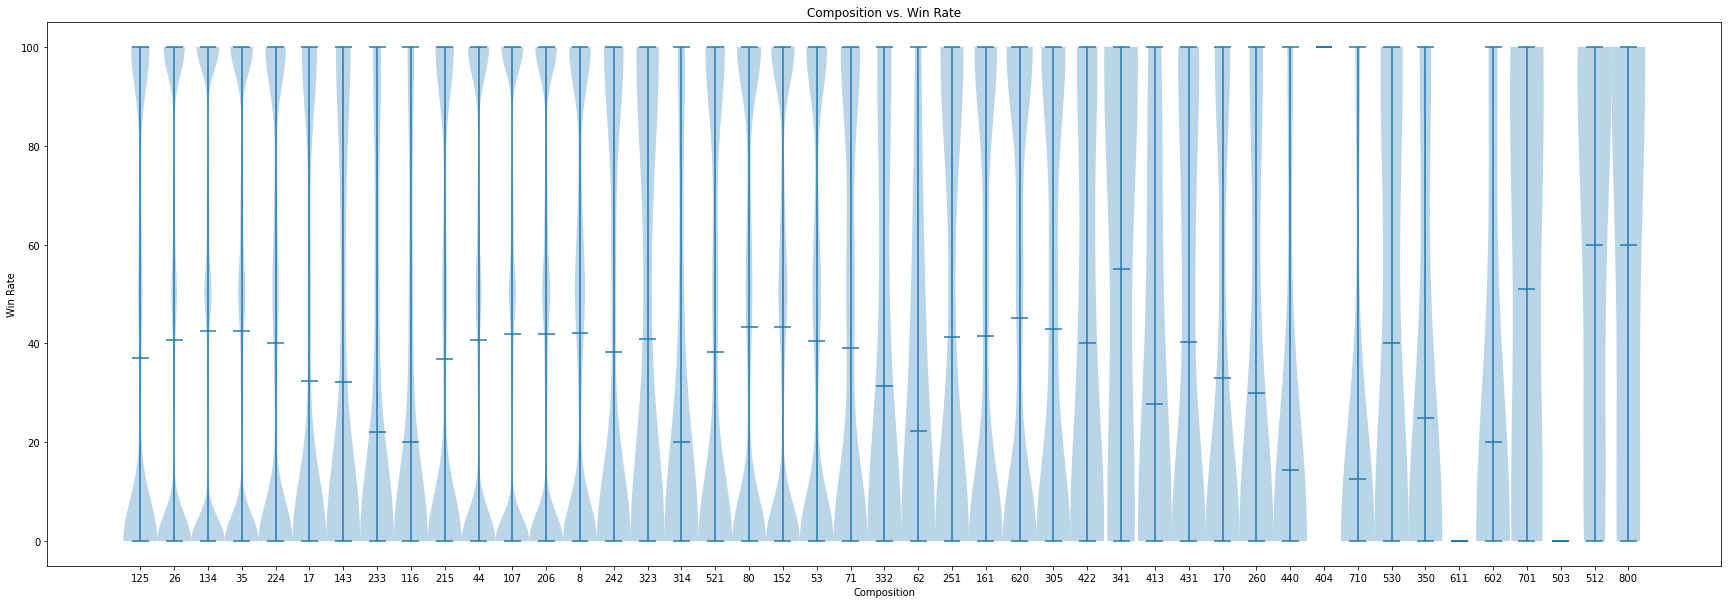

In [172]:
# Constructing Violin Plot
fig, ax = plt.subplots(figsize=(30,10))
# getting year data
compos = data_win_rate["composition"].unique()
temp_comp = list(range(0, len(compos)))
# getting all data for each year
win_rate_per_comp = []
data_win_rate.groupby("composition").apply(lambda x: win_rate_per_comp.append(x["win_rate"]))
# constructing plot
ax.violinplot(win_rate_per_comp,temp_comp,widths=1,showmeans=True)
# setting labels and title
ax.set_xlabel("Composition")
ax.set_ylabel("Win Rate")
ax.set_title("Composition vs. Win Rate")
ax.set_xticks(temp_comp)
ax.set_xticklabels(compos)
fig.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
win_rate = np.array(data_win_rate['win_rate'])
comp = np.array(data_win_rate["composition"]).reshape(-1, 1)

# Creating linear regression
regr = LinearRegression()
regr.fit(comp,win_rate)

# Printing out relevant information
print("Intercept:", regr.intercept_)
print("Coefficient:", regr.coef_[0])

Intercept: 41.80679635505383
Coefficient: -0.0002613058393928199


In [102]:
# Getting data to be used in predictions
d = {'card1': [], 'card2': [], 'card3': [], 'card4': [], 'card5': [], 'card6': [],'card7': [], 'card8': [], 'tier': []}
data_deck_tiers = pd.DataFrame(d)

c1 = []
c2 = []
c3 = []
c4 = []
c5 = []
c6 = []
c7 = []
c8 = []
tiers = []

def tier(deck,rank):
    c1.append(deck[0])
    c2.append(deck[1])
    c3.append(deck[2])
    c4.append(deck[3])
    c5.append(deck[4])
    c6.append(deck[5])
    c7.append(deck[6])
    c8.append(deck[7])
    if(rank >= 50):
        tiers.append('A')
    #elif(rank >= 37.846639):
    #    tiers.append('B')
    else:
        tiers.append('B')

data_win_rate['tier'] = data_win_rate[data_win_rate['occurences'] > 1].apply(lambda x: tier(x['deck'],x['win_rate']), axis=1)
data_deck_tiers['card1'] = c1
data_deck_tiers['card2'] = c2
data_deck_tiers['card3'] = c3
data_deck_tiers['card4'] = c4
data_deck_tiers['card5'] = c5
data_deck_tiers['card6'] = c6
data_deck_tiers['card7'] = c7
data_deck_tiers['card8'] = c8
data_deck_tiers['tier'] = tiers
data_deck_tiers.head()

,card1,card2,card3,card4,card5,card6,card7,card8,tier
0,10,14,21,30,38,74,87,98,B
1,4,36,42,46,50,62,87,95,A
2,0,26,30,41,77,90,91,98,B
3,6,34,35,37,63,92,99,102,A
4,0,1,10,72,80,82,87,98,A


In [118]:
data_A = data_deck_tiers[data_deck_tiers['tier'] == 'A'].sample(n=30000, random_state=1)

data_B = data_deck_tiers[data_deck_tiers['tier'] == 'B'].sample(n=30000, random_state=1)

data_B

data_training = data_A.append(data_B)
data_training

/tmp/ipykernel_136/155264557.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_training = data_A.append(data_B)


,card1,card2,card3,card4,card5,card6,card7,card8,tier
60071,6,10,18,29,37,45,88,99,A
74208,11,13,16,17,18,46,49,59,A
27754,9,12,13,17,22,37,87,95,A
63251,1,10,11,26,30,32,80,104,A
68733,25,31,54,59,68,85,87,98,A
...,...,...,...,...,...,...,...,...,...
33450,10,11,31,32,77,90,98,105,B
66733,0,6,35,41,45,49,95,99,B
18969,5,14,16,55,58,80,95,98,B
71862,11,12,24,39,64,77,88,94,B


In [119]:
# Create a random forest model that predicts if a deck will be winning or losing and display confusion matrix, accuracy of >= 60% is acceptable

# Import random forest classifier class
from sklearn import ensemble
forest = ensemble.RandomForestClassifier(n_estimators=50,max_depth=8)

# Split our data into train and test sets using holdout validation
var_train, var_test, res_train, res_test = train_test_split(data_training[['card1','card2','card3','card4','card5','card6','card7','card8']], data_training['tier'])

# Find best params for the random forest
rfc = ensemble.RandomForestClassifier()
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]
    
}

# Code taken from here https://www.datasciencelearner.com/how-to-improve-accuracy-of-random-forest-classifier/
from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(rfc,parameters,cv=5)
cv.fit(var_train,res_train.values.ravel())
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
display(cv)

Best parameters are: {'max_depth': 8, 'n_estimators': 100}


0.508 + or -0.003 for the {'max_depth': 2, 'n_estimators': 5}
0.51 + or -0.003 for the {'max_depth': 2, 'n_estimators': 10}
0.51 + or -0.002 for the {'max_depth': 2, 'n_estimators': 50}
0.511 + or -0.002 for the {'max_depth': 2, 'n_estimators': 100}
0.511 + or -0.004 for the {'max_depth': 2, 'n_estimators': 250}
0.509 + or -0.005 for the {'max_depth': 4, 'n_estimators': 5}
0.51 + or -0.004 for the {'max_depth': 4, 'n_estimators': 10}
0.512 + or -0.003 for the {'max_depth': 4, 'n_estimators': 50}
0.511 + or -0.003 for the {'max_depth': 4, 'n_estimators': 100}
0.512 + or -0.004 for the {'max_depth': 4, 'n_estimators': 250}
0.508 + or -0.004 for the {'max_depth': 8, 'n_estimators': 5}
0.508 + or -0.002 for the {'max_depth': 8, 'n_estimators': 10}
0.51 + or -0.004 for the {'max_depth': 8, 'n_estimators': 50}
0.514 + or -0.003 for the {'max_depth': 8, 'n_estimators': 100}
0.513 + or -0.003 for the {'max_depth': 8, 'n_estimators': 

51.946666666666665


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


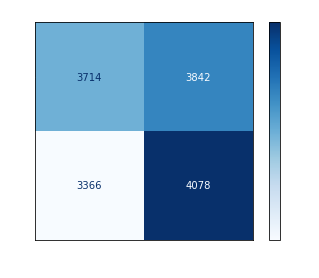

In [120]:
# Fit the data using the train_test_split
forest = forest.fit(var_train, res_train)

# Find and print the accuracy
print(forest.score(var_test, res_test)*100)

from sklearn.metrics import confusion_matrix
res_pred = forest.predict(var_test)
cm = confusion_matrix(res_test, res_pred)
from sklearn.metrics import plot_confusion_matrix
 
color = 'white'
matrix = plot_confusion_matrix(forest, var_test, res_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [121]:
# Create a decision tree model that predicts if a deck will be winning or losing and display confusion matrix, accuracy of >= 60% is acceptable

# Import decision tree classifier class
from sklearn import tree
decision_tree = tree.DecisionTreeClassifier()

# Fit the data using the train_test_split
decision_tree = decision_tree.fit(var_train, res_train)

# Find and print the accuracy
print(decision_tree.score(var_test, res_test)*100)

50.22666666666667


In [122]:
# Create an lda model that predicts if a deck will be winning or losing and display confusion matrix, accuracy of >= 60% is acceptable

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

lda = lda.fit(var_train, res_train)

# Find and print the accuracy
print(lda.score(var_test, res_test)*100)

50.9


In [177]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr


win_rate = data_win_rate['win_rate']

units = data_win_rate['composition'].apply(lambda x: int(x[2]))

corr, p = pearsonr(win_rate, units)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %.6f' % p)
corr, p = spearmanr(win_rate, units)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %.7f' % p)

spells = data_win_rate['composition'].apply(lambda x: int(x[1]))

corr, p = pearsonr(win_rate, spells)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %.6f' % p)
corr, p = spearmanr(win_rate, spells)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %.13f' % p)

buildings = data_win_rate['composition'].apply(lambda x: int(x[0]))

corr, p = pearsonr(win_rate, buildings)
print('Pearsons correlation: %.3f' % corr)
print('Pearsons correlation pval: %.3f' % p)
corr, _ = spearmanr(win_rate, buildings)
print('Spearman correlation: %.3f' % corr)
print('Spearman correlation pval: %.3f' % p)

Pearsons correlation: -0.006
Pearsons correlation pval: 0.000706
Spearman correlation: -0.009
Spearman correlation pval: 0.0000004
Pearsons correlation: 0.008
Pearsons correlation pval: 0.000002
Spearman correlation: 0.013
Spearman correlation pval: 0.0000000000002
Pearsons correlation: -0.001
Pearsons correlation pval: 0.422
Spearman correlation: -0.002
Spearman correlation pval: 0.422


In [174]:
units = data_win_rate['composition'].apply(lambda x: x[2])
units

0         5
1         6
2         4
3         5
4         4
         ..
327653    5
327654    6
327655    5
327656    5
327657    5
Name: composition, Length: 327658, dtype: object